# Modeling Ants Scouting Behavior in Cities.

Authors: Sam Ghalayini

## Background
---
Swarm intelligence is highly useful for ants. In this notebook we will look at how to model ants using swarm intelligence to search for food and bring it back home while leaving a trail of pheromones. An ant colony survies by each ant coordinating with each other. When an ant leaves the nest it starts dropping pheromones for two reasons, so other ants can follow their path and so once food is found the ant can find its way back home.
After many ants following a food source a path is 'established'. A path can be considered established when an ant can walk and follow pheromones without having to decide which path to take.

### Goal and Common Problems
---
The goal of this project is to have many ants leave a nest looking for multiple food sources and then find their way back to the nest and terminate. There were many problems considered such as the decay rate of pheromones, how to structure the graph data, and most importantly how to have ants decide which path to take. There are many cases which needed to be handled such as ants going into a dead-end street, ants going in circles like the video below, and how does an ant chose when they are given many paths with varying pheromone concentrations. 
![](videos/ant_mill_circle.gif)

### Layout
---
The code below contains the classes:
- city - initializes the graph and city of choice 
- food_pheromone - initializes and handles all pheromones of all ant agents
- ant_agent - makes one ant agent with the purpose of finding food and returning home

In [1]:
# Things to add
# 
# adversarial nest
# danger pheromones
# play with pheromone decay and whatnot 


## Code
---

### Libraries 

In [2]:
from threading import Thread, get_ident
import time
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from time import sleep
import pandas as pd
import random
import os, shutil
import geopandas as gpd
import concurrent.futures
from shapely.geometry import Point, LineString
import plotly_express as px
import osmnx as ox
# Used for interactive city location
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, IntSlider
from IPython.display import display
from geopy.geocoders import Nominatim
# import contextily as ctx
import time




In [3]:
ox.config(use_cache=True, log_console=True)

### City Class

In [4]:
class city():
    """
    This class creates a graph based off of a city using Open Street Maps.
    
    This is accomplished by sending it coordinates (Latitude,Longitude).
    
    Init
    ----
        Parameters
        ----------
        lat : float
            latitude of city
        lon :
            longitude of city
        size : int
            radius from center you want to include in the map
        network_type : str
            chose which types of edges you want to include
            ‘drive’ – get drivable public streets (but not service roads)
            ‘drive_service’ – get drivable public streets, including service roads
            ‘walk’ – get all streets and paths that pedestrians can use (this network type ignores one-way directionality)
            ‘bike’ – get all streets and paths that cyclists can use
            ‘all’ – download all (non-private) OSM streets and paths
            ‘all_private’ – download all OSM streets and paths, including private-access ones

    """
    def __init__(self, lat,lon,size,network_type,name):
        self.graph = ox.graph_from_point((lat, lon), dist=size, network_type=network_type)
        fig = plt.figure()
        fig, ax = ox.plot_graph(self.graph,node_color='w',node_edgecolor='w',node_size=10, node_zorder=3, edge_color='w', edge_linewidth=2, close=True)
        fig.savefig('images/'+name+'/'+'aph'+'.jpg', dpi = 100)
    def make_two_way_streets(self):
        """
        For each A-B node in self.graph make sure there is a B-A node
        """
#         print("starting len", len(list(self.graph.edges(keys=False))))
        remove_edges = []
        for key,value,n in self.graph.edges(keys=True):
            if n > 0:
                remove_edges.append((key,value))
        self.graph.remove_edges_from(remove_edges)
        counter = 0
        for edge in self.graph.edges(keys=False):
            if (edge[1],edge[0]) not in self.graph.edges:
                edge_to_add = (edge[1],edge[0])
                self.graph.add_edge(*edge_to_add, 
                           length = self.graph.edges[(edge[0],edge[1],0)]['length'], 
#                            highway = self.graph.edges[(edge[0],edge[1],0)]['highway'],
#                            osmid = self.graph.edges[(edge[0],edge[1],0)]['osmid'],
#                            oneway = self.graph.edges[(edge[0],edge[1],0)]['oneway']
                          )
#         print("ending len",len(list(self.graph.edges(keys=True))))

In [5]:
# # delete 
# # control groups [rome, paris, LA]
# input_city_lat = [41.8933203, 48.8566, 37.7790262]
# input_city_lon = [12.4829321, 2.3522, -122.419906]
# num_agents = [20, 20 ,20]
# num_food_sources = [3, 3, 3]
# map_size = [400, 400, 400]
# control_group = 2
# chosen_city_obj = city(lat = input_city_lat[control_group], lon = input_city_lon[control_group], size=map_size[control_group], network_type='drive', name = 'chosen_city')  
# chosen_city_obj.make_two_way_streets()

### Food Pheromone Class

In [6]:
class food_pheromone(object):
    """
    This class stores and manipulates pheromones that ants drop on edges
    
    Parameters
    ----------
        graph : city object
        nest : int
    """
    def __init__(self, graph,nests):
        self.food_in_nest = 0
        self.counter = 1
        self.graph = graph 
        self.pheromone = dict.fromkeys(self.graph.edges(), [0,0])
        self.pheromone_empty = {}
        self.discovered_nodes = []
        self.ec = []
        self.nc = []
        self.food_source = []
        self.nests = nests
        
    def add_pheromone(self, edge, release_amount,nest):
        """
        Add given pheromone amount to given edge(A,B) and edge(B,A).
        
        Parameters
        ----------
            edge : tuple
            release_amount : int
        """
#         print(self.pheromone)
#         self.pheromone[edge][0] += release_amount
#         self.pheromone[(edge[1],edge[0])][0] += release_amount
#         self.pheromone[(edge[1],edge[0])][1] = nest
        
        if (edge[0], edge[1]) in list(self.pheromone_empty.keys()):
            self.pheromone_empty[(edge[0], edge[1])][0] += release_amount
            self.pheromone_empty[(edge[0],edge[1])][1] = nest
        else:
            self.pheromone_empty[(edge[0],edge[1])] = [release_amount, nest]
#         print("add food: ", self.pheromone)
        
    def add_global_pheromone(self, amount):
        """
        Add pheromone to each edge in graph
        
        Parameters
        ----------
            amount : int
        """
        for key,value in self.pheromone.items():
            self.pheromone[key] += (amount)
            
    def decay_pheromone(self,color_start,amount):
        """
        Subtract an amount from each edge that has pheromones until it has reached 0.
        
        Parameters
        ----------
            amount : int
        """
        for key,value in self.pheromone_empty.items():
#             if value > color_start: 
#                 if ((self.pheromone[key] - amount) < color_start):
#                     self.pheromone[key] = color_start
#                     self.pheromone[(key[0],key[1])] = color_start
#                 else:
#                     self.pheromone[key] -= amount
#                     self.pheromone[(key[0],key[1])] -= amount
            self.pheromone[key][0] = max((self.pheromone[key][0]-(self.pheromone[key][0]*amount)),color_start)
            self.pheromone_empty[key][0] = max((self.pheromone_empty[key][0]-(self.pheromone_empty[key][0]*amount)),color_start)


        
                
    def edge_weight(self, edge):
        """
        Return edge weight
        
        Parameters
        ----------
            edge : tuple
        """
#         if self.pheromone_empty[edge] not in self.pheromone_empty:
#             return 0
        try:
            return self.pheromone_empty[edge][0]
        except:
            return 0
#         return self.pheromone_empty[edge][0]
    
    def update_graph(self, pheromone_release, name, color_start):
        """
        Update graph with new edge and node colors based off of pheromone concentration on edge. 
        Save each plot as a unique image.
        
        Parameters
        ----------
            pheromone_release : int
        """
        self.ec = []
        col1 = sns.color_palette("rocket", 100,as_cmap=False)
        col2 = sns.color_palette("mako", 100, as_cmap=False)
        for start, end in self.graph.edges(keys=False):
            try:
                if(self.pheromone_empty[(start,end)][0] > color_start and self.pheromone_empty[(start,end)][1] == 298082887): # this value 40 is dependent on other things with the execution code
                    if (self.pheromone_empty[(start,end)][0] >= 99):
                        self.pheromone_empty[(start,end)][0] = 99
                    this_color = col1[max(int(self.pheromone_empty[(start,end)][0]),6)]
#                     print("first ", int(self.pheromone_empty[(start,end)][0]))
                    col = '#'+str(hex(int(this_color[0]*255))[2:]+hex(int(this_color[1]*255))[2:]+hex(int(this_color[2]*255))[2:])
                    if int(self.pheromone_empty[(start,end)][0]) == 0:
                           self.ec.append('white')
                           continue
                    if int(self.pheromone_empty[(start,end)][0]) == 1:
                           self.ec.append('#4a2201')
                           continue
                    if int(self.pheromone_empty[(start,end)][0]) == 2:
                           self.ec.append('#4d2301')
                           continue
                    if int(self.pheromone_empty[(start,end)][0]) == 3:
                           self.ec.append('#4d2301')
                           continue
                    if int(self.pheromone_empty[(start,end)][0]) == 4:
                           self.ec.append('#4d2301')
                           continue
                    if int(self.pheromone_empty[(start,end)][0]) == 5:
                           self.ec.append('#4d2301')
                           continue
                    self.ec.append(col)
            except:
                self.ec.append('white')
            try:
                if(self.pheromone_empty[(start,end)][0] > color_start and self.pheromone_empty[(start,end)][1] != 298082887): # this value 40 is dependent on other things with the execution code
                    if (self.pheromone_empty[(start,end)][0] >= 99):
                        self.pheromone_empty[(start,end)][0] = 99
                    this_color = col2[max(int(self.pheromone_empty[(start,end)][0]),6)]
#                     print("second ", int(self.pheromone_empty[(start,end)][0]))
                    col = '#'+str(hex(int(this_color[0]*255))[2:]+hex(int(this_color[1]*255))[2:]+hex(int(this_color[2]*255))[2:])
                    if int(self.pheromone_empty[(start,end)][0]) == 0:
                           self.ec.append('white')
                           continue
                    if int(self.pheromone_empty[(start,end)][0]) == 1:
                           self.ec.append('#4a2201')
                           continue
                    if int(self.pheromone_empty[(start,end)][0]) == 2:
                           self.ec.append('#4d2301')
                           continue
                    if int(self.pheromone_empty[(start,end)][0]) == 3:
                           self.ec.append('#4d2301')
                           continue
                    if int(self.pheromone_empty[(start,end)][0]) == 4:
                           self.ec.append('#4d2301')
                           continue
                    if int(self.pheromone_empty[(start,end)][0]) == 5:
                           self.ec.append('red')
                           continue
                    self.ec.append(col)
            except:
                self.ec.append('white')
#         print(self.ec)
        self.nc = ['white' if (n in self.discovered_nodes and not self.is_food_source(n) and not self.is_nest(n)) else '' 'lime' if (self.is_food_source(n) and not self.is_nest(n)) else '' 'orange' if (self.is_nest(n)) else 'midnightblue' for n in self.graph.nodes]
        fig = plt.figure()
        fig, ax = ox.plot_graph(self.graph,node_color=self.nc,node_size=25, 
              node_zorder=3, edge_color=self.ec, edge_linewidth=2, close=True,bgcolor = 'white')
        fig.savefig('images/'+name+'/'+'graph'+str(self.counter)+'.jpg', dpi = 100)
        self.counter += 1
        
    def add_discovered_node(self,node):
        """
        Add given node to list contianing nodes accessed.
        
        Parameters
        ----------
            node : int
        """
        self.discovered_nodes.append(node)
        
    def is_nest(self,node):
        """
        Is given node the nest wehre ants are spawned.
        
        Parameters
        ----------
            node : int
        """
        if (node in self.nests):
            return True
        return False
        
    def make_food_source(self, location):
        """ 
        Make given nodes a food source.
        
        Parameters
        ----------
            location : array
        """
        for i in range(len(location)):
            self.food_source.append(location[i])
    
    def print_food_sources(self):
        """
        Print food sources.
        """
        print("There are food sources here:", self.food_source)
    
    def is_food_source(self,location):
        """
        Check if given node is a food source.
        
        Parameters
        ----------
            location : int
        """
        if location in self.food_source:
            return True
        
    def nest_increment(self):
        """
        Increment food in nest by 1
        """
        self.food_in_nest += 1
        
    def nest_food_amount(self):
        """ 
        Return amount of food in nest
        """
        return self.food_in_nest
    
    def found_food(self, location, nest,amount=2):
        options = [(start, end) for start, end in self.graph.edges(keys=False) if (start==location)]
        options = dict.fromkeys(options, 0)
#         print("WHAT IS BEING CALLED? I SHOULD HAVE FOUND FOOD: ",options)
        for key,values in options.items():
            self.add_pheromone(key,amount, nest)

        

### Ant Class

In [7]:
class ant_agent(object):
    """
    This class creates an agent which traverses the given graph dropping pheromones on each edge looking for food sources.
    Once food source is found the agent returns home and terminates.
    
    Parameters
    ----------
        graph : city object
        nest : int
        food : food_pheromone object
        pheromone_release : int
        name : str
    """
    def __init__(self, graph, nests, food, pheromone_release, name):
        self.location = random.choice(nests)
        self.graph = graph
        self.nest = self.location
        self.total_edges_walked = 0
        self.food = food
        self.has_food = False
        self.previous_node = self.nest
        self.pheromone_release = pheromone_release
#         food.add_discovered_node(self.nest)
        self.name = name
    def move(self):
        """
        This method has two main loops for agent to traverse graph until a food source is reached then head back to where it started.
        Method prints updates on location and current goal of agent.
        """
#         print("Looking for food: ", self.name)
        while (not self.has_food):
            if isinstance(self.location,int):
                edge_choice = self.scout_food_from_node()
                self.location = edge_choice
                self.previous_node = edge_choice[0]
                
                node_choice = self.walk_along_edge(edge_choice)
                self.location = node_choice
                food.add_discovered_node(self.location)
                
                if food.is_food_source(self.location):
                    self.has_food = True
#                     print("Found food: ", self.name)
                    
#                 self.food.update_graph(pheromone_release, self.name)
            else:
                print("Invalid Location")
            self.total_edges_walked += 1
        food.found_food(self.location,self.nest, self.pheromone_release)
#         print("Heading back to the nest: ", self.name)
        self.previous_node = self.location
        
        while (self.has_food):
            if isinstance(self.location,int):
                edge_choice = self.return_home_with_food()
                self.location = edge_choice
                self.previous_node = edge_choice[0]
            
                node_choice = self.walk_along_edge(edge_choice)
                self.location = node_choice
                food.add_discovered_node(self.location)
                
                if (self.food.is_nest(self.location)):
                    self.has_food = False
#                     print("At nest with food: ", self.name)
                    
#                 self.food.update_graph(self.pheromone_release, self.name)
            else:
                print("Invalid Location")
            self.total_edges_walked += 1
            
        food.nest_increment()
        print("Amount of food in the nest: ",food.nest_food_amount(), ": ", self.name)
        print("Steps taken: ",self.total_edges_walked, ": ", self.name)
        
    def scout_food_from_node(self):
        """
        Chose path to take from node. 
        If there is only way to walk then agent is at a dead end and chose that path.
        If not in a dead end then delete path from where it came from.
        If all paths have no pheromones then chose random path
        Finally chose path with weighted probability with relationship to how many pheromones are on the edge.
        """
        options = [(start, end) for start, end in self.graph.edges(keys=False) if (start==self.location)]
        options = dict.fromkeys(options, 0)
        
        for key,value in options.items():
            options[key] = self.food.edge_weight(key)
        # go back if in dead end
        if (len(options.items()) == 1):
            return list(options.keys())[0]
        # delete path it came from
        try:
            del options[(self.location,self.previous_node)]
            del options[(self.previous_node,self.location)]
        except:
            None          
        # all paths are same pheromone amounts
        all_new = len(list(set(list(options.values())))) == 1
        if all_new:
            key = random.choice(list(options.keys()))
            return key
        # weighted probability choice
        weighted_paths = list(options.keys())
        weighted_values = list(options.values())
        
        choice = random.choices(weighted_paths, weights = weighted_values, k = 1)
        probExplore = (1/((1+self.total_edges_walked)**0.4))
        choice = random.choices(weighted_paths, weights = weighted_values, k = 1)
        if random.choices([True,False], weights = [probExplore,1-probExplore], k = 1)[0]:
            # take random path with 0 pheromones
            weighted_values = [1]*len(weighted_values)
            choice = random.choices(weighted_paths, weights = weighted_values, k = 1)
#         print(weighted_paths)
#         print(weighted_values)
#         print(choice[0])
        return choice[0]
    
    def return_home_with_food(self):
        """
        After food has been found return home.
        Similar to scout_food_from_node method.
        """
        options = [(start, end) for start, end in self.graph.edges(keys=False) if (start==self.location)]
        options = dict.fromkeys(options, 0)
        for key,value in options.items():
            options[key] = self.food.edge_weight(key)
        # if only way is back the way we came then go that way
        if (len(options.items()) == 1): 
            return list(options.keys())[0] 
        # all new paths
        all_new = len(list(set(list(options.values())))) == 1
        if all_new:
            key = random.choice(list(options.keys()))
            return key
        # delete path it came from
        try: 
            del options[(self.location,self.previous_node)]
            del options[(self.previous_node,self.location)]
        except:
            None
        # weighted random choice
        weighted_paths = list(options.keys())
        weighted_values = list(options.values())
        return random.choices(weighted_paths, weights = weighted_values, k = 1)[0]
    
    def walk_along_edge(self, edge):
        """
        Have agent walk along path for given length, can include sleep(0.001) to model ant taking time to walk
        
        Parameters
        ----------
            edge : tuple
        """
        length = (self.graph.edges[(edge[0],edge[1],0)]['length'])
        self.food.add_pheromone(edge, self.pheromone_release, self.nest)
        while(length > 0):
            length -= 1
            sleep(0.0001)
        sleep(0.04)
        return edge[1]
    def pause(self):
        time.sleep(5)
        
    def kill(self):
        print("THIS ANT DIED, nest: ", self.nest, " name: ", self.name)
        self.location = self.nest
        return 

## Results
--- 
Below are the mode and videos for running multiple ants in San Francisco, Washington D.C., and Rome.  
The nest location and food sources are chosen at random for each run.

In [8]:
import random
random.seed(24)

In [9]:
# control groups [rome, paris, LA]
input_city_lat = [41.8933203, 48.8566, 37.7790262]
input_city_lon = [12.4829321, 2.3522, -122.419906]
num_agents = [1, 1 ,1]
num_food_sources = [3, 3, 3]
map_size = [400, 400, 400]

### Ant Generator

In [10]:
def same_loc(ants, graph):
    dic = []
    locs = []
#     dic = dict(zip(graph.nodes(),[[]]*len(graph.nodes())))
    dic = {}
    locs = [ants[i].location for i in range(len(ants))]
    for i in range(len(locs)):
        if isinstance(locs[i],tuple):
            # change later , going to node or coming
            locs[i] = locs[i][1]
        if locs[i] in list(dic.keys()):
            dic[locs[i]].append(i)
        else:
            dic[locs[i]] = [i]
#         print(dic)
    for keys, values in list(dic.items()):
        if len(values) > 2:
            col1 = 0
            col2 = 0
            for i in range(len(values)):
                if ants[values[i]].nest == 298082887:
                    col1 += 1
                else: 
                    col2 += 1
            if col1 > col2:
                for i in range(len(values)):
                    if 298082887 != ants[values[i]].nest:
                        ants[values[i]].kill()
            elif col2 > col1:
                for i in range(len(values)):
                    if 298082887 == ants[values[i]].nest:
                        ants[values[i]].kill()
            else:
                for i in range(len(values)):
                    ants[values[i]].pause()
    
#     counts = []
#     for i in range(len(locs)):
#         counts.append(locs.count(locs[i]))
#     for i in range(len(counts)):
#         if counts[i] > 1:
#             same_index = [i for i, x in enumerate(source) if x == counts[i]]
#             print(same_index)
#             ants[i].pause()
#     print(counts)

<Figure size 432x288 with 0 Axes>

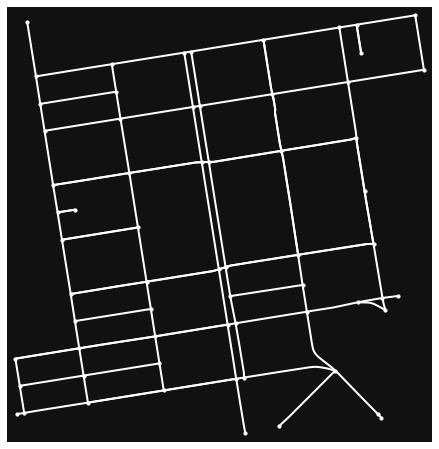

<Figure size 432x288 with 0 Axes>

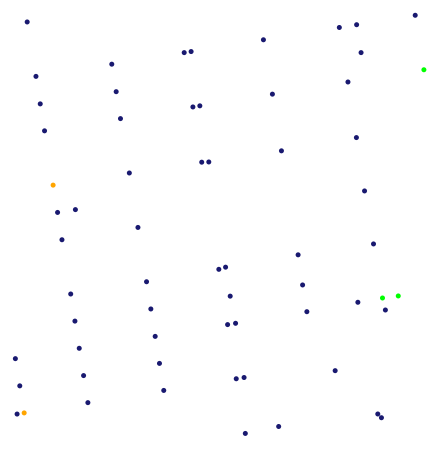

<Figure size 432x288 with 0 Axes>

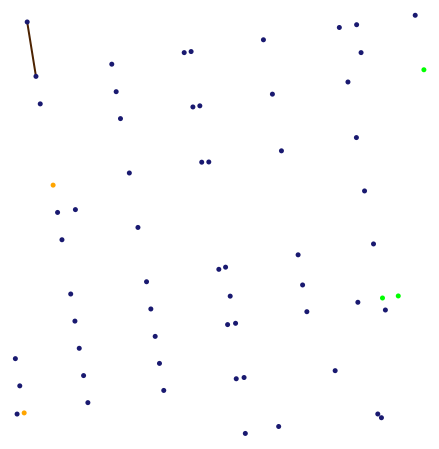

<Figure size 432x288 with 0 Axes>

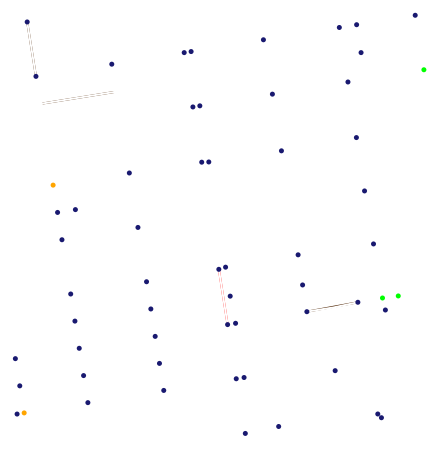

<Figure size 432x288 with 0 Axes>

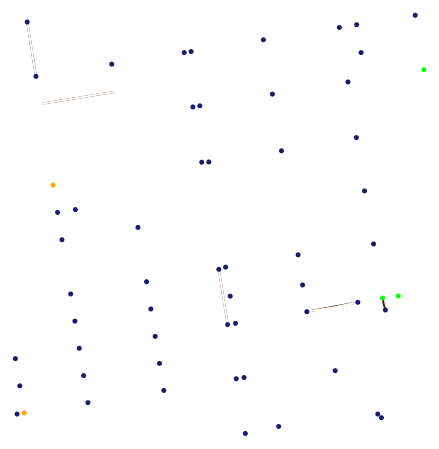

<Figure size 432x288 with 0 Axes>

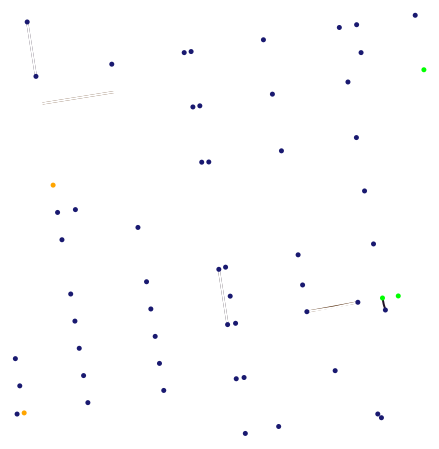

<Figure size 432x288 with 0 Axes>

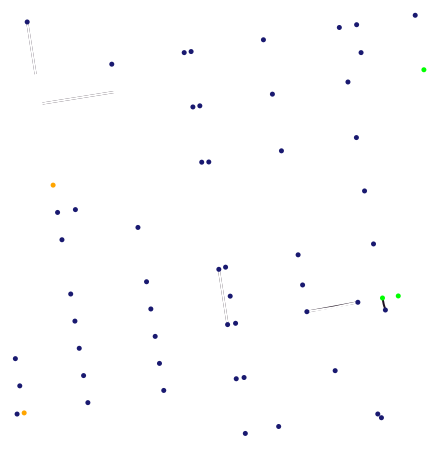

<Figure size 432x288 with 0 Axes>

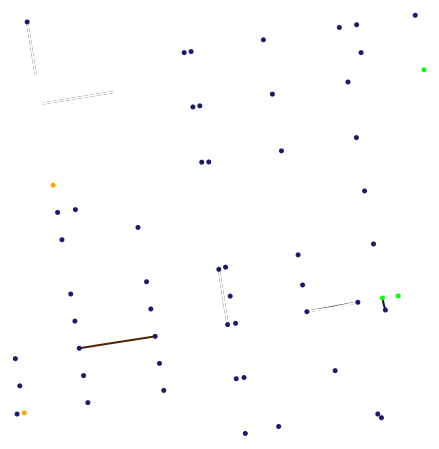

<Figure size 432x288 with 0 Axes>

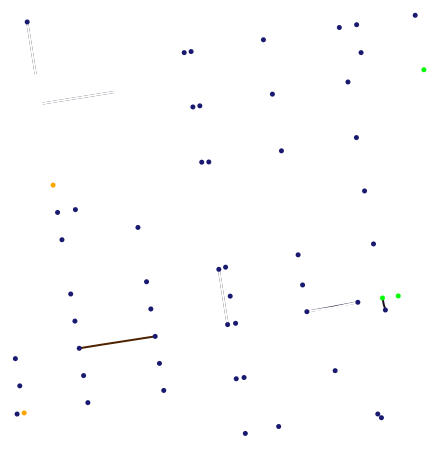

<Figure size 432x288 with 0 Axes>

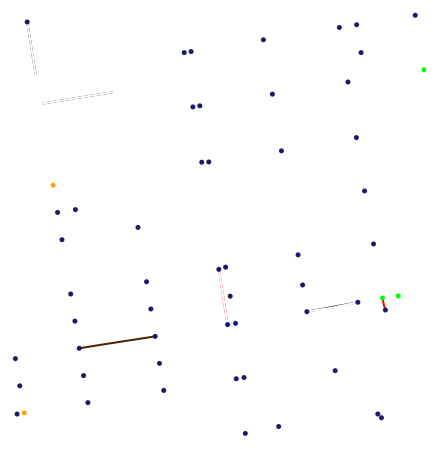

<Figure size 432x288 with 0 Axes>

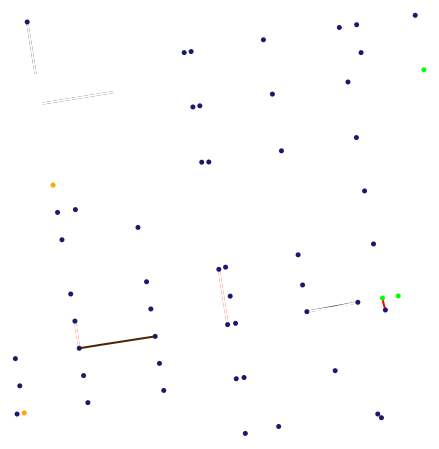

<Figure size 432x288 with 0 Axes>

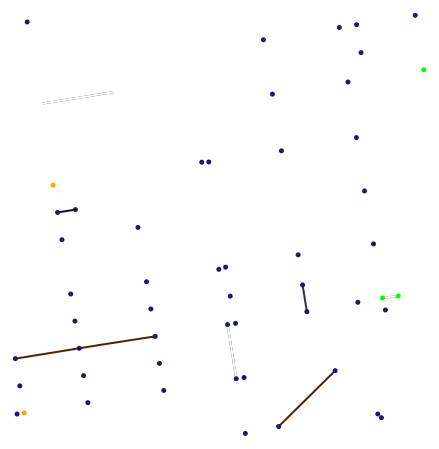

<Figure size 432x288 with 0 Axes>

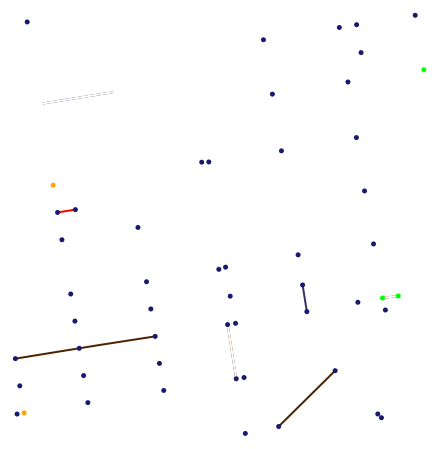

<Figure size 432x288 with 0 Axes>

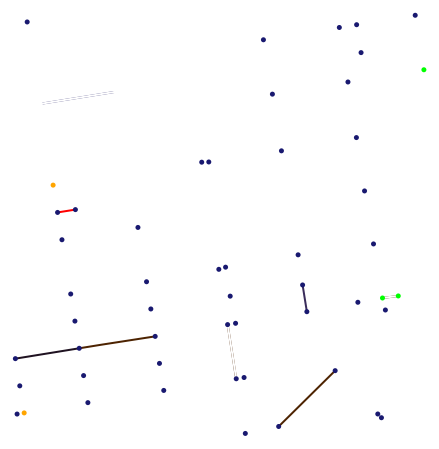

<Figure size 432x288 with 0 Axes>

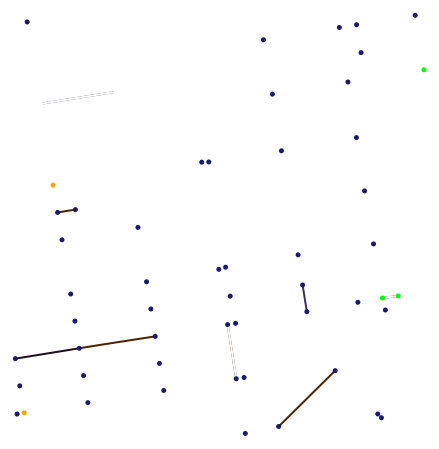

<Figure size 432x288 with 0 Axes>

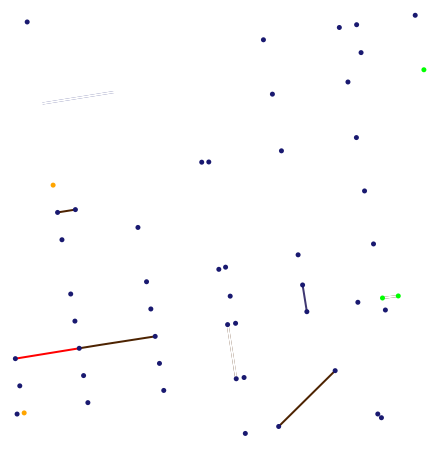

<Figure size 432x288 with 0 Axes>

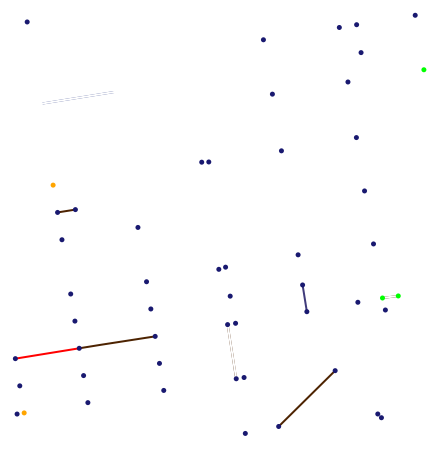

<Figure size 432x288 with 0 Axes>

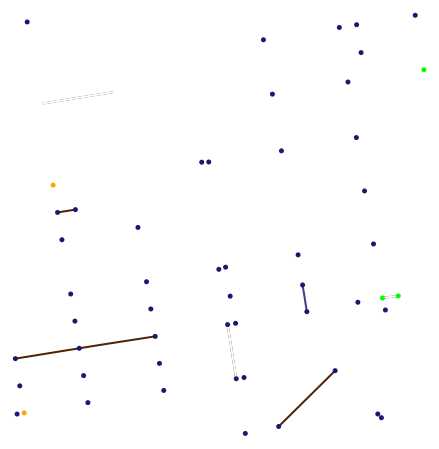

<Figure size 432x288 with 0 Axes>

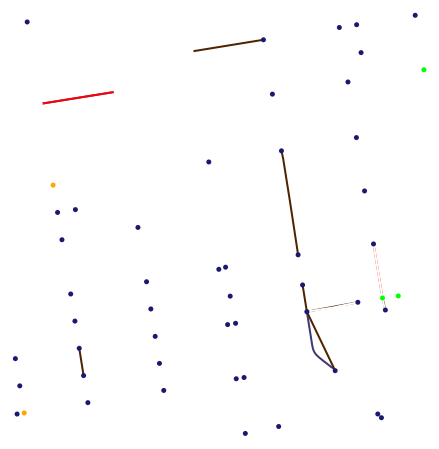

<Figure size 432x288 with 0 Axes>

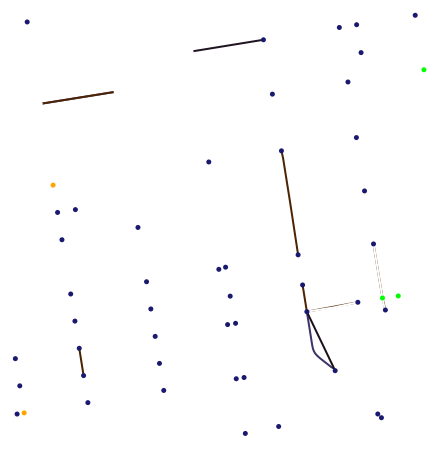

<Figure size 432x288 with 0 Axes>

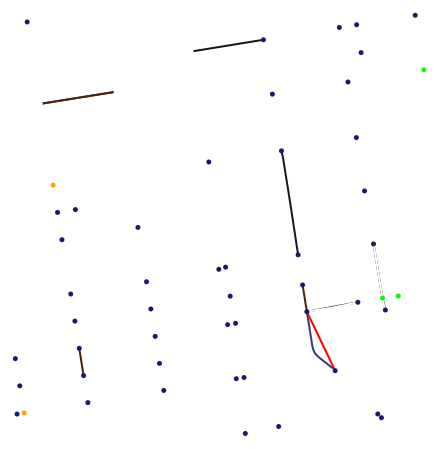

<Figure size 432x288 with 0 Axes>

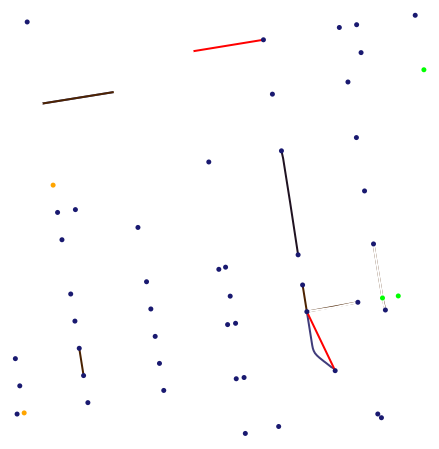

<Figure size 432x288 with 0 Axes>

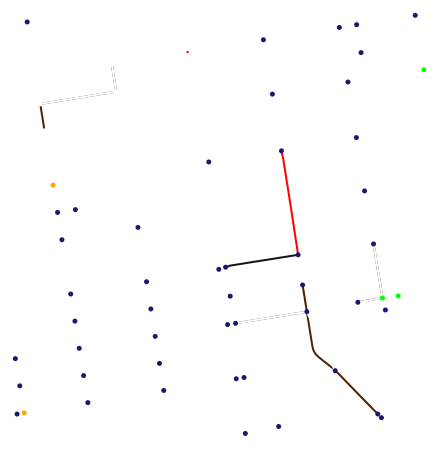

<Figure size 432x288 with 0 Axes>

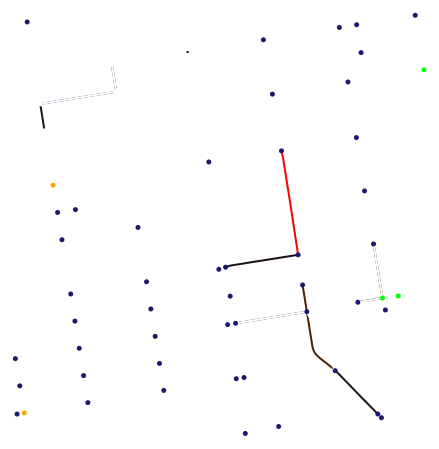

<Figure size 432x288 with 0 Axes>

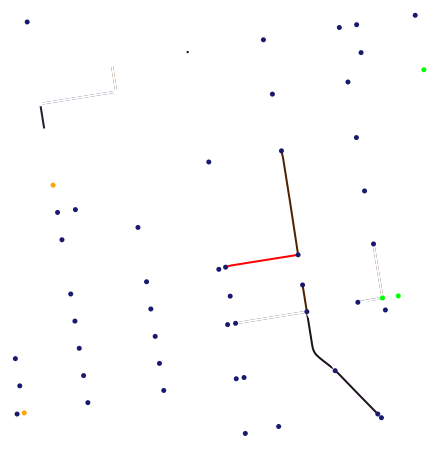

<Figure size 432x288 with 0 Axes>

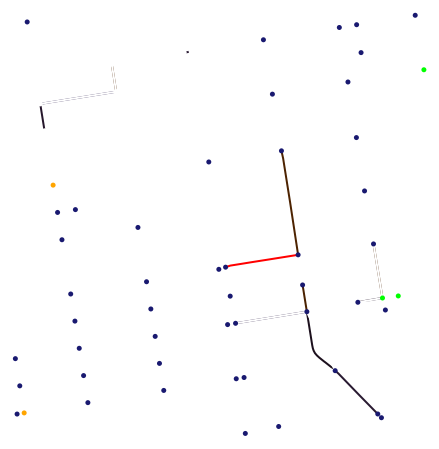

<Figure size 432x288 with 0 Axes>

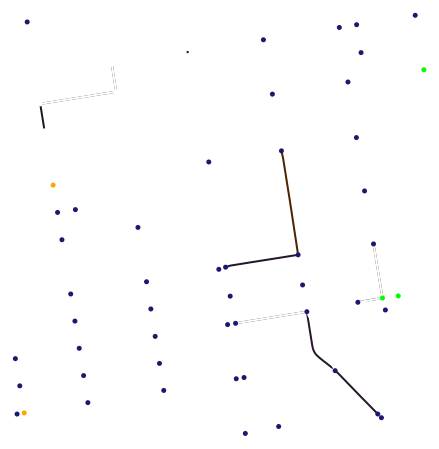

<Figure size 432x288 with 0 Axes>

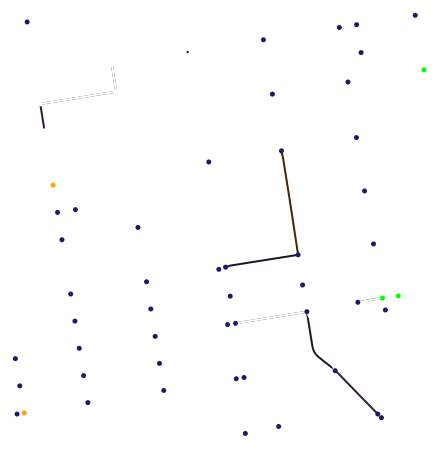

<Figure size 432x288 with 0 Axes>

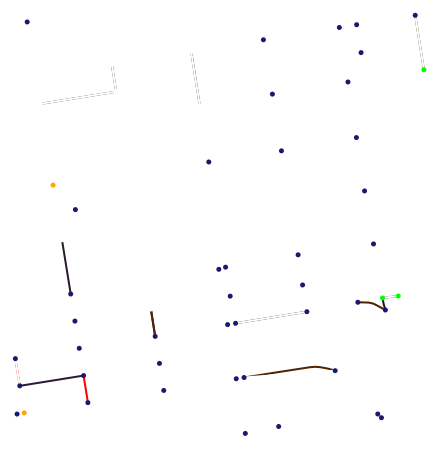

<Figure size 432x288 with 0 Axes>

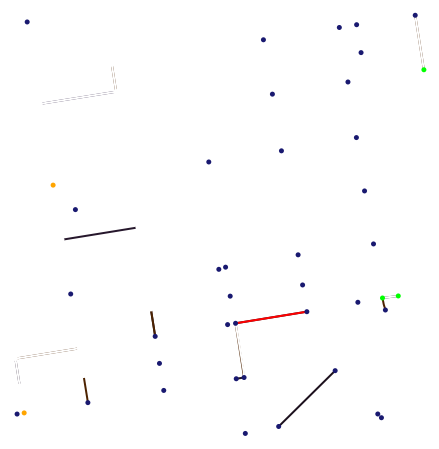

<Figure size 432x288 with 0 Axes>

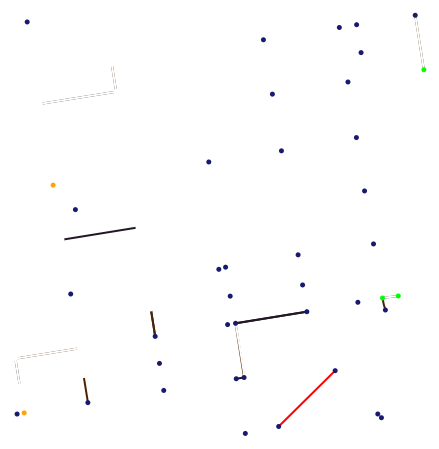

<Figure size 432x288 with 0 Axes>

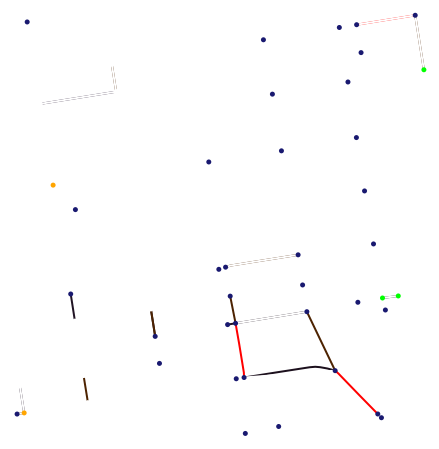

<Figure size 432x288 with 0 Axes>

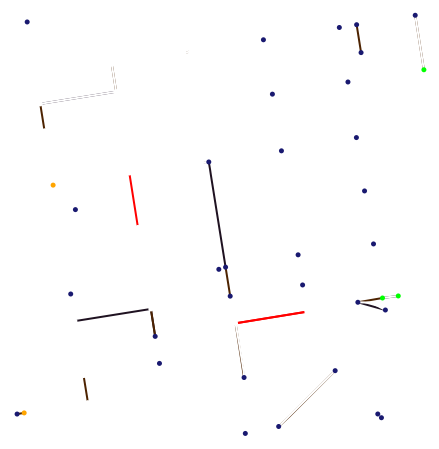

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/Users/samghala/opt/miniconda3/lib/python3.9/threading.py", line 954, in _bootstrap_inner
    self.run()
  File "/Users/samghala/opt/miniconda3/lib/python3.9/threading.py", line 892, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-7-b1fbfb5cf237>", line 55, in move
  File "<ipython-input-7-b1fbfb5cf237>", line 145, in return_home_with_food
  File "/Users/samghala/opt/miniconda3/lib/python3.9/random.py", line 494, in choices
    raise ValueError('Total of weights must be greater than zero')
ValueError: Total of weights must be greater than zero


<Figure size 432x288 with 0 Axes>

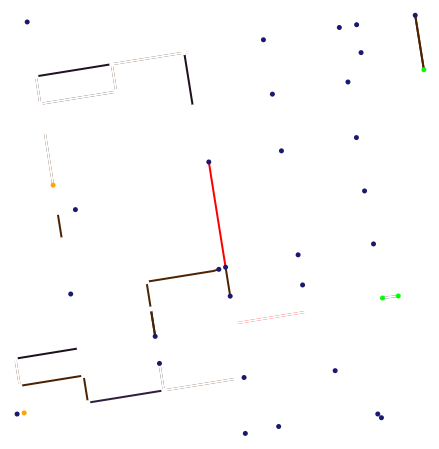

In [11]:


group_steps = []

# for control_group in range(len(input_city_lat)):

    # Initialize food class
# pheromone_ratio = [[1,3],[2,3],[3,3],[4,3],[5,3],[6,3],[7,3],[8,3],[9,3],[10,3]]
pheromone_ratio = [[5,0.1]]
# pheromone_release = 5 # free var
# pheromone_decay = 3 # free var, 3 is lowest number possible
color_start = 0 # free var
init_release = 0.1 # free var
release_rate = 0.2 # free var
control_group = 2
amount_of_food_sources = num_food_sources[control_group]
num_ants = num_agents[control_group]
    
for pheromone_release,pheromone_decay in pheromone_ratio:
    # Initialize city class
    chosen_city_obj = city(lat = input_city_lat[control_group], lon = input_city_lon[control_group], size=map_size[control_group], network_type='drive', name = 'chosen_city')  
    chosen_city_obj.make_two_way_streets()

    # Initialize nest, food sources, and set color pheromone variable 
#     nest_1 = random.choice(list(chosen_city_obj.graph.nodes())) # random nest
#     nest_2 = random.choice(list(chosen_city_obj.graph.nodes())) # random nest
#     nests = [nest_1, nest_2]
    nests = [298082887, 65329089]
#     food_sources = random.choices(list(chosen_city_obj.graph.nodes()),k=amount_of_food_sources) # chose k food sources
    food_sources = [65308272, 4061806120, 65325363]
    food = food_pheromone(chosen_city_obj.graph,nests) 
    food.make_food_source(food_sources)
#     food.add_global_pheromone(color_start)
    food.add_discovered_node(298082887)
    food.add_discovered_node(65329089)

    # make list of ant agent objects names 'abc'
    ants = list()
    for i in range(num_ants):
        ants.append(ant_agent(chosen_city_obj.graph, nests,food, pheromone_release, name = 'abc'+str(i)))

    # make list of ant agent objects that are threads
    t_ants = []
    for i in range(num_ants):
        t_ants.append(Thread(target=ants[i].move))

    # at start release 10% of ants
    for i in range(int(num_ants*init_release)):
        t_ants[i].start()

    # release the other 90% of ants one every release_rate seconds 
    for i in range(int(num_ants*init_release),num_ants):
        food.decay_pheromone(color_start,pheromone_decay)
        food.update_graph(pheromone_release, 'chosen_city', color_start)
        time.sleep(release_rate)
        t_ants[i].start()

    # save graph every 0.01 seconds and decay pheromones 
    for i in range(num_ants):
        while(t_ants[i].is_alive()):
            food.decay_pheromone(color_start,pheromone_decay)
            sleep(0.1)
            same_loc(ants,chosen_city_obj.graph)
            food.update_graph(pheromone_release, 'chosen_city', color_start)

    # wait for all ants to stop
    for i in range(num_ants):
        t_ants[i].join()

    steps = []
    for i in range(len(ants)):
        steps.append(ants[i].total_edges_walked)
    group_steps.append(steps)

In [ ]:
# graph steps taken over time
a = np.arange(len(ants))

fig, axs = plt.subplots(3, 3)

axs[0, 0].bar(a,group_steps[0])
axs[0, 1].bar(a,group_steps[1])
axs[0, 2].bar(a,group_steps[2])
axs[1, 0].bar(a,group_steps[3])
axs[1, 1].bar(a,group_steps[4])
axs[1, 2].bar(a,group_steps[5])
axs[2, 0].bar(a,group_steps[6])
axs[2, 1].bar(a,group_steps[7])
axs[2, 2].bar(a,group_steps[8])
# steps = []
for ax in axs.flat:
    ax.set(xlabel='Ants', ylabel='Steps')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()


# plt.bar(a,group_steps[0])
# plt.xlabel("Ant")
# plt.ylabel("Steps Taken")
# plt.title("Steps taken for each ant to find food and return to a nest")
# plt.figure(figsize=(8, 6), dpi=80)
# plt.bar(a,group_steps[1])
# plt.xlabel("Ant")
# plt.ylabel("Steps Taken")
# plt.title("Steps taken for each ant to find food and return to a nest")
# plt.figure(figsize=(8, 6), dpi=80)
# plt.bar(a,group_steps[2])
# plt.xlabel("Ant")
# plt.ylabel("Steps Taken")
# plt.title("Steps taken for each ant to find food and return to a nest")

In [ ]:
# delete all photos
folder = 'images/chosen_city'
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

## Color code

(0.01831941, 0.0229766, 0.10738511)
0x451b


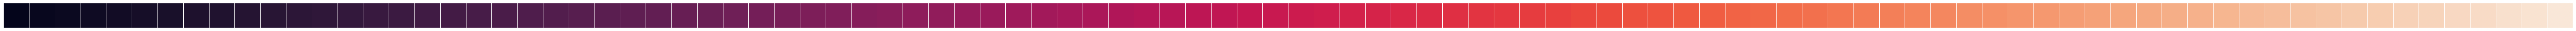

In [22]:

sns.set(rc={'figure.figsize': (1,1)})
current_palette = sns.color_palette("rocket", 100,as_cmap=False)
# current_palette = sns.color_palette("mako", 100, as_cmap=False)
sns.palplot(current_palette)
this_color = current_palette[0]

print(this_color)
my_color = str(hex(int(this_color[0]*255))+hex(int(this_color[1]*255))[2:]+hex(int(this_color[2]*255))[2:])

print((my_color))
